In [6]:
from tensorflow.keras.datasets import cifar10 # Для датасета cifar10
from tensorflow.keras.models import Sequential # Для создания последовательной модели
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization # Слои для свёрточной сети
from tensorflow.keras.optimizers import Adam, Adadelta # Оптимизаторы, для задания шага обучения
from tensorflow.keras import utils # Для One Hot Encoding, т.е. представления верного ответа в виде 1 и 0 для неверных ответов, но возможных ответов.
from tensorflow.keras.preprocessing import image # Для отрисовки изображений
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Для отрисовки графиков
from PIL import Image # Для работы с изображениями
import random # Для генерации случайных чисел 
import math # Для округления

%matplotlib inline

In [7]:
# Загрузка датасета и верных ответов из Cifar10
(x_train, y_train_original), (x_test, y_test_original) = cifar10.load_data()

In [8]:
# Вывод размерностей обучающей и тестовой выборок
print("Обучающая выборка:")
print(x_train.shape)
print()

print("Правильные ответы в обучающей выборке:")
print(y_train_original.shape)
print()

print("Тестовая выборка:")
print(x_test.shape)
print()

print("Правильные ответы в тестовой выборке:")
print(y_test_original.shape)
print()

Обучающая выборка:
(50000, 32, 32, 3)

Правильные ответы в обучающей выборке:
(50000, 1)

Тестовая выборка:
(10000, 32, 32, 3)

Правильные ответы в тестовой выборке:
(10000, 1)



In [9]:
# Определение названия лейблов для классифицируемых изображений
labels = ['Самолет', 'Автомобиль', 'Птица', 'Кот', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

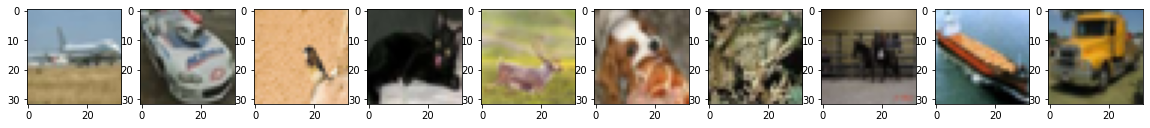

Правильные ответы: 0(Самолет); 1(Автомобиль); 2(Птица); 3(Кот); 4(Олень); 5(Собака); 6(Лягушка); 7(Лошадь); 8(Корабль); 9(Грузовик); 


In [10]:
# Вывод картинок и их лэйблов (верных ответов)

fig, axs = plt.subplots(1, 10, figsize=(20, 3)) # Создание полотна для вывода 10 изображений
y = ''
for i in range(10): # Заполнение полотна
  label_indexes = np.where(y_train_original==i)[0] # Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) # Случайным образом выбираем из списка индекс
  img = x_train[index] # Выбираем из x_train соответствующее изображение
  label = y_train_original[index][0] # Берем ответ, который записан в 0 эл массива.
  y += str(label) + "("+labels[label]+"); " # Сохраняем лэйблы для каждой картинки
  axs[i].imshow(Image.fromarray(img)) # Отображаем полотно

plt.show()
print("Правильные ответы:", y)

In [11]:
# Превращаем выборки верных ответов в формат one hot encoding
y_train = utils.to_categorical(y_train_original, 10)
y_test = utils.to_categorical(y_test_original, 10)

print("Обучающая выборка:")
print(y_train_original[5], "->", y_train[5])
print(y_train_original[234], "->", y_train[234])
print(y_train_original[45477], "->", y_train[45477])
print(y_train_original[14848], "->", y_train[14848])
print()

print("Тестовая выборка:")
print(y_train_original[15], "->", y_train[15])
print(y_train_original[334], "->", y_train[334])
print(y_train_original[8477], "->", y_train[8477])
print(y_train_original[3768], "->", y_train[3768])

Обучающая выборка:
[1] -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[6] -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[5] -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0] -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Тестовая выборка:
[9] -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[3] -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[2] -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[7] -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [12]:
# Разделение тестовой выборки на проверочную и тестовую
x_val = x_test[0:8000]
y_val = y_test[0:8000]

x_test = x_test[8000:]
y_test = y_test[8000:]


In [13]:
# Проверка размерностей выборок

print("Обучающая выборка:")
print(x_train.shape)
print(y_train.shape)
print()

print("Проверочная выборка:")
print(x_val.shape)
print(y_val.shape)
print()

print("Тестовая выборка:")
print(x_test.shape)
print(y_test.shape)

Обучающая выборка:
(50000, 32, 32, 3)
(50000, 10)

Проверочная выборка:
(8000, 32, 32, 3)
(8000, 10)

Тестовая выборка:
(2000, 32, 32, 3)
(2000, 10)


Сверточная нейронная сеть

In [14]:
# batch_size - кол. эл. выборки, с которыми идёт работа до изменения весов.
batch_size = 64

# Conv2D() был протестирован с разными размерами окна свёртки. С 3х3 даёт лучшие результаты, поэтому оставляю его.

# Создание последовательную модели
model = Sequential()
# Слой пакетной нормализации. Для приведения подаваемых в н.с. данных к диапазону от 0 до 1. Улучшает обучение
model.add(BatchNormalization(input_shape=(32, 32, 3), name="bn0"))

# Группа слоев 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer1"))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer1"))
model.add(Dropout(0.25, name="Dropout-layer1"))
model.add(BatchNormalization(name = "bn1"))

# Группа слоев 2. Выявляем больше признаков
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name="Conv2D-layer3"))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name="Conv2D-layer4"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer2"))
model.add(Dropout(0.25, name="Dropout-layer2"))
model.add(BatchNormalization(name = "bn2"))

# Группа слоев 3. Выявляем больше признаков
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name="Conv2D-layer5"))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name="Conv2D-layer6"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer3"))
model.add(Dropout(0.25, name="Dropout-layer3"))
model.add(BatchNormalization(name = "bn3"))


model.add(BatchNormalization())
# Слой преобразования данных из 2D представления в 1 мерный массив
model.add(Flatten(name="flatten"))
# Выходной полносвязный классифицирующий слой
model.add(Dense(10, activation='softmax', name = "labels"))

# Компилируем сеть
# По умолчанию optimizer=Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [15]:
# Вывод структуры н.с.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bn0 (BatchNormalization)    (None, 32, 32, 3)         12        
                                                                 
 Conv2D-layer1 (Conv2D)      (None, 32, 32, 32)        896       
                                                                 
 Conv2D-layer2 (Conv2D)      (None, 32, 32, 32)        9248      
                                                                 
 mp2D-layer1 (MaxPooling2D)  (None, 16, 16, 32)        0         
                                                                 
 Dropout-layer1 (Dropout)    (None, 16, 16, 32)        0         
                                                                 
 bn1 (BatchNormalization)    (None, 16, 16, 32)        128       
                                                                 
 Conv2D-layer3 (Conv2D)      (None, 16, 16, 64)        1

Epoch 1/20
782/782 [==============================] - 50s 25ms/step - loss: 1.4977 - accuracy: 0.4828 - val_loss: 1.1321 - val_accuracy: 0.6149
Epoch 2/20
782/782 [==============================] - 18s 23ms/step - loss: 0.9567 - accuracy: 0.6645 - val_loss: 0.7906 - val_accuracy: 0.7240
Epoch 3/20
782/782 [==============================] - 17s 22ms/step - loss: 0.7888 - accuracy: 0.7229 - val_loss: 0.7649 - val_accuracy: 0.7385
Epoch 4/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6981 - accuracy: 0.7552 - val_loss: 0.6625 - val_accuracy: 0.7757
Epoch 5/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6360 - accuracy: 0.7760 - val_loss: 0.6449 - val_accuracy: 0.7789
Epoch 6/20
782/782 [==============================] - 18s 23ms/step - loss: 0.5816 - accuracy: 0.7969 - val_loss: 0.6433 - val_accuracy: 0.7856
Epoch 7/20
782/782 [==============================] - 18s 23ms/step - loss: 0.5427 - accuracy: 0.8087 - val_loss: 0.6197 - val_accuracy:

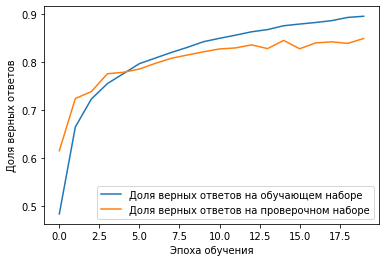

In [16]:
# Обучение н.с. на данных датасета Cifar10
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Вывод графика точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2746 - accuracy: 0.9018 - val_loss: 0.5076 - val_accuracy: 0.8512
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2728 - accuracy: 0.9023 - val_loss: 0.4841 - val_accuracy: 0.8491
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2666 - accuracy: 0.9032 - val_loss: 0.4973 - val_accuracy: 0.8484
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2518 - accuracy: 0.9096 - val_loss: 0.5403 - val_accuracy: 0.8425
Epoch 5/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2507 - accuracy: 0.9105 - val_loss: 0.5046 - val_accuracy: 0.8508
Epoch 6/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2427 - accuracy: 0.9120 - val_loss: 0.4960 - val_accuracy: 0.8520
Epoch 7/10
782/782 [==============================] - 17s 22ms/step - loss: 0.2366 - accuracy: 0.9161 - val_loss: 0.5146 - val_accuracy:

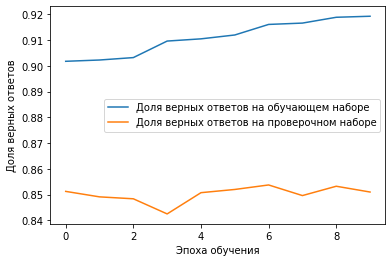

In [17]:
# Дообучение
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_val, y_val),
                    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Работа модели в реальных условиях

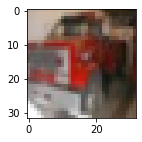

Выход сети:
[4.66528290e-04 4.92071882e-02 1.09227076e-01 1.64094978e-04
 3.85023304e-06 2.63289232e-02 3.72456736e-04 1.44678997e-04
 6.15514116e-03 8.07929993e-01]

0 -> 0.0004665282904170453548431396484375000000
1 -> 0.0492071881890296936035156250000000000000
2 -> 0.1092270761728286743164062500000000000000
3 -> 0.0001640949776628986001014709472656250000
4 -> 0.0000038502330426126718521118164062500000
5 -> 0.0263289231806993484497070312500000000000
6 -> 0.0003724567359313368797302246093750000000
7 -> 0.0001446789974579587578773498535156250000
8 -> 0.0061551411636173725128173828125000000000
9 -> 0.8079299926757812500000000000000000000000

Распознан объект:  9 - Грузовик
Верный ответ:  9 - Грузовик


In [19]:
prediction = model.predict(x_test)

# Выбор изображения
n = 1122 # 1022 # 1137 # 1132 # 1122

# Вывод изображения
img = x_test[n]
img = img.reshape(32, 32, 3)
img = img.astype('uint8')
plt.figure(figsize=(2, 2))
plt.imshow(Image.fromarray(img))
plt.show()

print("Выход сети:")
print(prediction[n])
print()
for i in range(10):
  print(i,"->", "{:.40f}".format(prediction[n][i]))
print()
print("Распознан объект: ", np.argmax(prediction[n]), "-", labels[np.argmax(prediction[n])])
print("Верный ответ: ", np.argmax(y_test[n]), "-", labels[np.argmax(y_test[n])])
